author: Samuel Begg

date: 06/04/2024

Compute Fisher information for a periodically driven XY model, as discussed in Mishra, Bayat, Phys. Rev. Lett. 127, 080504 (2021)

1. Define simulation parameters

In [1]:
import methods
import numpy as np
import scipy.linalg as lin
from datetime import datetime
import copy
from joblib import Parallel, delayed

stem0 = '/Users/samuelbegg/'
stem = stem0  + 'Documents/Projects/Sensing/'

# System parameters for periodic boundary condition spin chain
J = 1.0  # +ve is Ferromagnet [Hamiltonian as defined Mishra, Bayat, PRL 127, 080504 (2021)]
gamma = 0.4
sites = 4
h1_amp = 1.5
h1_period = 6.0/4.0 #period of the drive

# Initial state
initial_state = 'ground_state' 
# 'ground_state': starts in the system ground-state. 
# 'flips': manually flips specific spins (with the rest down), see below. Default: single flip. Odd number of excitations (spin) = even parity (fermions) = PBC. 
# 'momentum': a k = 0 momentum state. Even parity = PBC.
# 'spin_up': all spins up, odd number excitations (spin) = even parity = PBC, even number excitations (spin) = odd parity (fermions) = ABC

# Boundary conditions
boundary_conditions = 'ABC' 
# 'PBC' = periodic boundary conditions or 'ABC' = anti-periodic boundary conditions
# The boundary conditions must reflect the fermion parity in the initial conditions (see above).
# The Fourier transform definition is automatically adjusted based on number sites and boundary conditions, as in arXiv:1707.02400.

# Sensing parameters
phasepoints = 1 # number of points for calculating h0
h0mat = np.linspace(0.3, 0.3, phasepoints)  # range of h0 points to sample
sub_system_range = np.arange(1,4+1) # range of subsystem sizes for evaluating Fisher information

# Time parameters
dt = 0.01 # time step
times = 500 # number of steps
measure_interval = 1 #int(h1_period/dt) # evaluate Fisher information at particular times (if the period is rational then these are the times n \tau)
tvec = dt*np.arange(1,times+1)

# Computational
tol = 10**(-6) # when evaluating the Fisher information we don't consider singular terms for which |w[rr] + w[ss]| < tol 
shift = 0.001 # finite division size for calculating derivative of reduced density matrix, i.e. drho/dh0 ~ (rho(h0) - rho(h0 + shift))/shift for the order2 version
derivative_estimator = 'order2' # 2nd order = 'order2' or 4th order 'order4' approximation for the derivative of reduced density matrix
method = 'RK4' # integration method 'euler', 'heun' or 'RK4' 
integration_type = 'matrices' # perform integration with 'matrices' or 'loops' over individual elements (matrices is far more efficient)
num_cores = 16  # number of cores to parallelize with
save_results = 'bin' # 'save' or 'bin' (don't save)

h1 = h1_amp*np.sin(2*np.pi/(h1_period)*dt*np.arange(0,times)) # initialize periodic field


2. Initialize correlation matrices <c^{dag}_i c_j> and <c^{dag}_i c^{dag}_j>


In [2]:
obs, Dag_obs = methods.initialize_state(sites, gamma, J, h0mat[0], h1[0], boundary_conditions, initial_state)

3. Perform time-evolution for a range of h_0

In [3]:
Fisher_mat = []
particle_numberL = []
particle_numberR = []

#loop over h0
output = Parallel(n_jobs=num_cores)(delayed(methods.Fisher_Calc)(phase, obs, Dag_obs, J, gamma, h0mat[phase], shift, h1, times, dt, measure_interval, sites, sub_system_range, tol, derivative_estimator, integration_type, method, initial_state, boundary_conditions) for phase in range(0,phasepoints))

#collect output of parallel computation
for kk in range(0,phasepoints):
    
    data = output[kk]

    Fisher_mat = Fisher_mat + [data[0]]

    particle_numberL = particle_numberL + [data[1]]
    
    
#Calculate time average over 2nd half of time evolution to get steady state Fisher information

#initialize variables
time_tot = np.size(Fisher_mat[0][0,:])

Fisher_av = np.zeros([phasepoints,np.size(sub_system_range)])

#loop over h0 and subsystem size
for kk in range(0, phasepoints):

    for ss in range(0, np.size(sub_system_range)):
        #Extract steady state (or late time) Fisher information by averaging over final 10% of times
        Fisher_av[kk,ss] = Fisher_av[kk,ss] + np.mean(Fisher_mat[kk][ss,int(9*time_tot/10):int(time_tot)])



0 h0 value =  0.3
0
0:00:00.090591 End Simulation
0
0:00:00.049184 End Simulation
Simulations finished, reduced density matrices extracted. Now calculate Fisher information.
Analyse sub_system L = 1
Subsystem analaysis complete. Number of avoided divergences (average per time) = 0
Analyse sub_system L = 2
Subsystem analaysis complete. Number of avoided divergences (average per time) = 0
Analyse sub_system L = 3
Subsystem analaysis complete. Number of avoided divergences (average per time) = 8
Analyse sub_system L = 4


/Users/samuelbegg/Documents/Projects/Sensing/methods.py:868: ComplexWarning: Casting complex values to real discards the imaginary part
  Fisher[zzz,ttt] = Fisher_time


Subsystem analaysis complete. Number of avoided divergences (average per time) = 32
0:00:00.262580 End Fisher Calculation


4. Plot Results

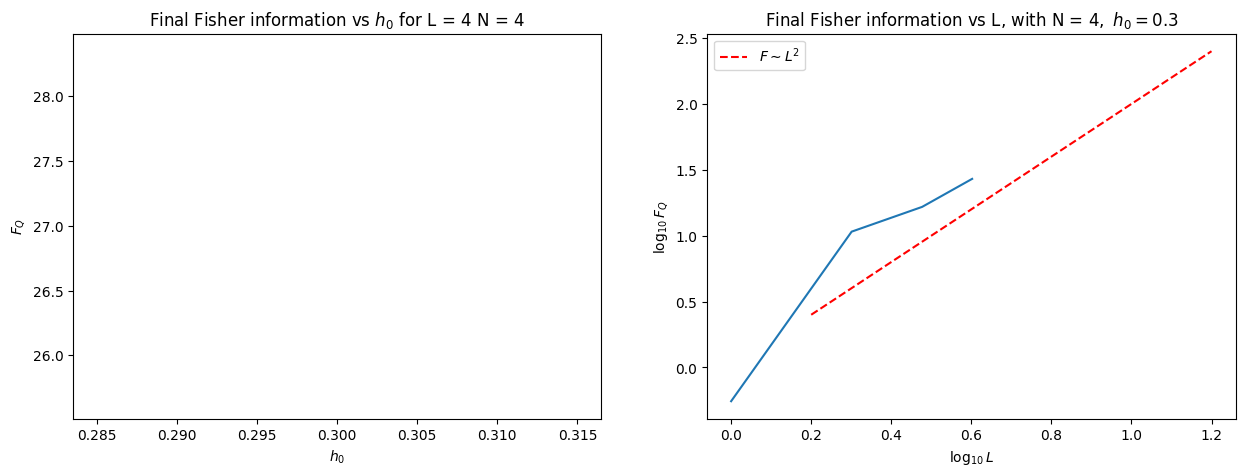

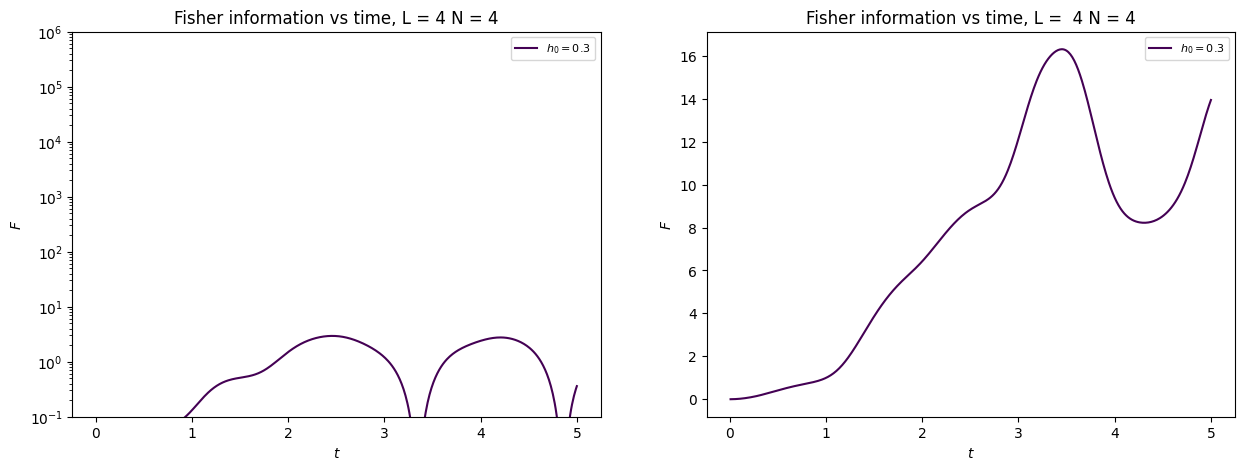

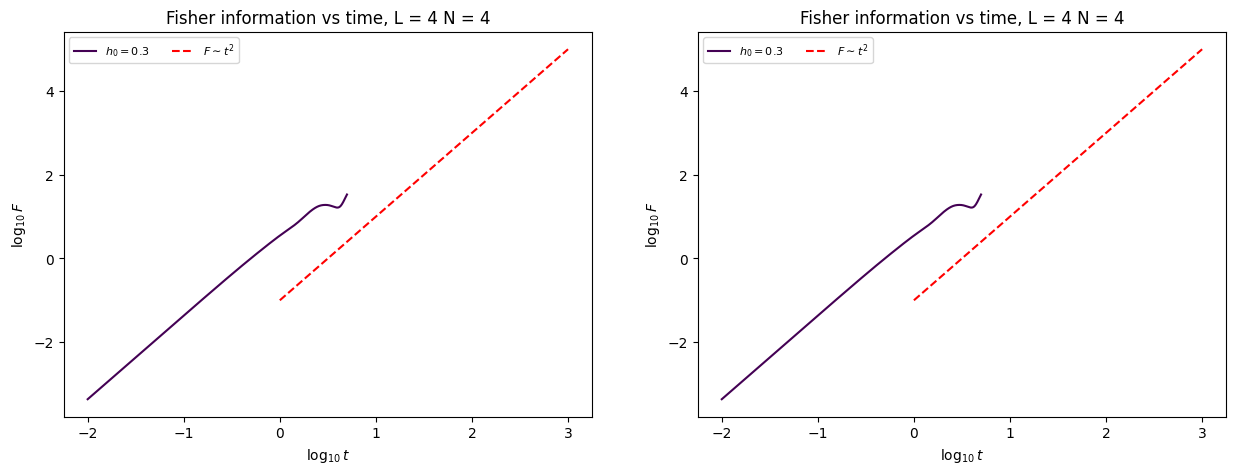

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
color = plt.cm.viridis(np.linspace(0,1,sites))
color2 = plt.cm.viridis(np.linspace(0,1,phasepoints))

#plot h0 vs Fisher for a specific subsystem size (here smallest one)
measure_tvec = measure_interval*dt*np.arange(1,len(Fisher_mat[0][0][:])+1)
tvec = measure_tvec

sub_system_plot_index = 3
fig1, ax = plt.subplots(1,2,figsize = (15,5))
ax0 = ax[0]
ax0.plot(h0mat,Fisher_av[:,sub_system_plot_index])
ax0.set_title(r'Final Fisher information vs $h_0$ for L = ' + str(sub_system_range[sub_system_plot_index]) + ' N = ' + str(sites))
ax0.set_xlabel(r'$h_0$')
ax0.set_ylabel(r'$F_Q$')
ax1 = ax[1]
ax1.set_title(r'Final Fisher information vs L, with' ' N = ' + str(sites) + r'$,~h_0=$' + str(np.round(h0mat[int(phasepoints/2)-1],3)))
ax1.plot(np.log10(sub_system_range),np.log10(Fisher_av[int(phasepoints/2)-1,:]))
x = np.linspace(0.2,1.2,1000)
ax1.plot(x,2*x,'r--',label = r'$F \sim L^{2}$')
ax1.set_xlabel(r'$\log_{10} L$')
ax1.set_ylabel(r'$\log_{10} F_Q$')
ax1.legend()
plt.show()

fig1, ax = plt.subplots(1,2,figsize = (15,5))
ax0 = ax[0]
ax1 = ax[1]
ax0.set_title(r'Fisher information vs time, L = ' + str(sub_system_range[sub_system_plot_index]) + ' N = ' + str(sites))
ax1.set_title(r'Fisher information vs time, L =  ' + str(sub_system_range[sub_system_plot_index])+ ' N = ' + str(sites))

for kk in range(0,phasepoints):
    #1.0/(h1_period)*
    if kk == 0:
        ax0.plot(measure_tvec,Fisher_mat[kk][0,:],color = color2[kk],label = r'$h_0 = $' + str(np.round(h0mat[kk],4)) )
        ax1.plot(measure_tvec,Fisher_mat[kk][1,:],color = color2[kk],label = r'$h_0 = $' + str(np.round(h0mat[kk],4)) )
    elif kk == phasepoints-1:
        ax0.plot(measure_tvec,Fisher_mat[kk][0,:],color = color2[kk],label = r'$h_0 = $' + str(np.round(h0mat[kk],4)) )
        ax1.plot(measure_tvec,Fisher_mat[kk][1,:],color = color2[kk],label = r'$h_0 = $' + str(np.round(h0mat[kk],4)) )
    else:
        ax0.plot(measure_tvec,Fisher_mat[kk][0,:],color = color2[kk])
        ax1.plot(measure_tvec,Fisher_mat[kk][1,:],color = color2[kk])

ax0.set_ylabel(r'$F$')
ax0.set_xlabel(r'$t$')
ax1.set_ylabel(r'$F$')
ax1.set_xlabel(r'$t$')
ax0.legend(ncol = 2,fontsize = 8)
ax1.legend(ncol = 2,fontsize = 8)
ax0.set_ylim(0.1,10**6)
ax0.set_yscale('log')
plt.show()


x = np.linspace(0,3,1000)
#Plot Heisenberg scaling to guide the eye
fig1, ax = plt.subplots(1,2,figsize = (15,5))
ax0 = ax[0]
ax1 = ax[1]
ax0.set_title(r'Fisher information vs time, L = ' + str(sub_system_range[sub_system_plot_index]) + ' N = ' + str(sites))
ax1.set_title(r'Fisher information vs time, L = ' + str(sub_system_range[-1]) + ' N = ' + str(sites))
for kk in range(0,phasepoints):
    if kk == 0:
        ax0.plot(np.log10(measure_tvec),np.log10(Fisher_mat[kk][sub_system_plot_index,:]),color = color2[kk],label = r'$h_0 = $' + str(np.round(h0mat[kk],4)))
        ax1.plot(np.log10(measure_tvec),np.log10(Fisher_mat[kk][-1,:]),color = color2[kk],label = r'$h_0 = $' + str(np.round(h0mat[kk],4)))
    elif kk == phasepoints-1:
        ax0.plot(np.log10(measure_tvec),np.log10(Fisher_mat[kk][sub_system_plot_index,:]),color = color2[kk],label = r'$h_0 = $' + str(np.round(h0mat[kk],4)))
        ax1.plot(np.log10(measure_tvec),np.log10(Fisher_mat[kk][-1,:]),color = color2[kk],label = r'$h_0 = $' + str(np.round(h0mat[kk],4)))
    else:
        ax0.plot(np.log10(measure_tvec),np.log10(Fisher_mat[kk][sub_system_plot_index,:]),color = color2[kk])
        ax1.plot(np.log10(measure_tvec),np.log10(Fisher_mat[kk][-1,:]),color = color2[kk])
ax0.plot(x,2*x-1,'--r',label = r'$F \sim t^{2}$')
ax1.plot(x,2*x-1,'--r',label = r'$F \sim t^{2}$')
ax0.set_ylabel(r'$\log_{10} F$')
ax0.set_xlabel(r'$\log_{10} t$')
ax1.set_ylabel(r'$\log_{10} F$')
ax1.set_xlabel(r'$\log_{10} t$')
ax0.legend(ncol = 2,fontsize = 8)
ax1.legend(ncol = 2,fontsize = 8)
plt.show()


if phasepoints > 1:
    fig1, ax = plt.subplots(1,2,figsize = (15,5))
    ax0 = ax[0]
    ax1 = ax[1]

    for kk in range(0,phasepoints):
        
        numberL = particle_numberL[kk]

        ax0.plot(tvec,np.real(numberL[0,:]),color = color2[kk],label = r'$h_0 = $' + str(np.round(h0mat[kk],3)))
        ax0.set_ylabel(r'$n_0(t)$')
        ax0.set_xlabel(r'$t$')

        hchoice = 0 #int(phasepoints/2)+4
        # plot a single realization
        if kk == hchoice:
            for mm in range(0,sites):
                ax1.plot(tvec,np.real(numberL[mm,:]),'--',label = str(mm),color = color[mm])
                ax1.set_ylabel(r'$n_j$')
                ax1.set_xlabel(r'$t$')
                #plt.legend()

    ax0.set_title(r'Density vs time for site j = 0, for all $h_0$ values')      
    ax1.set_title(r'Density vs time for all sites with  $h_0=$' + str(h0mat[hchoice]))  
    #ax0.legend()
    plt.show()


if save_results == 'save':
    
    np.save('Results/h0mat.npy',h0mat)
    np.save('Results/measure_tvec.npy',measure_tvec)
    np.save('Results/Fisher_mat.npy',Fisher_mat)


Comparisons against ED/direct integration

[0.15973339+0.j 0.15973339+0.j 0.15973339+0.j 0.15973339+0.j]


/Users/samuelbegg/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/samuelbegg/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


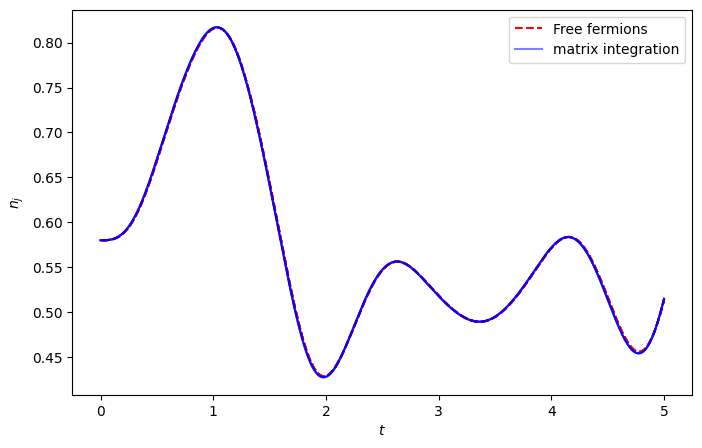

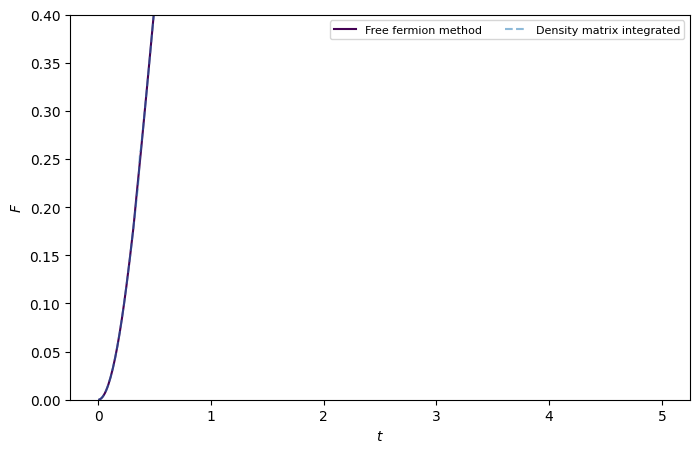

In [5]:
fig1, ax = plt.subplots(1,1,figsize = (8,5))
ax1 = ax
    
matrixplot = 'yes'
edplot = 'no'

numberL = particle_numberL[0]
for mm in range(0,sites):

    ax1.plot(tvec,np.real(numberL[mm,:]),'--r')

    if mm == 0:

        ax1.plot(tvec,np.real(numberL[mm,:]),'--r',label = 'Free fermions')

if matrixplot == 'yes':

    mag_matrix = np.load(stem + 'matrix_results/magsites.npy')    

    print(mag_matrix[:,0])

    for mm in range(0,3):

        ax1.plot(0.001*np.arange(0,np.size(mag_matrix,1)),0.5*mag_matrix[mm,:] + 0.5,'-b',alpha =0.5)   

        if mm == 0:

            ax1.plot(0.001*np.arange(0,np.size(mag_matrix,1)),0.5*mag_matrix[mm,:] + 0.5,'-b',alpha =0.5,label ='matrix integration')   


if edplot == 'yes':

    mag_ed = np.load(stem + 'ed_results/magsites.npy')    

    dted = 0.01

    for mm in range(0,3):
        
        ax1.plot(dted*np.arange(0,np.size(mag_ed,1)),mag_ed[mm,:] + 0.5,'-k',markersize = 1,alpha =0.5)    

        if mm == 0:

            ax1.plot(dted*np.arange(0,np.size(mag_ed,1)),mag_ed[mm,:] + 0.5,'-k',markersize = 1,label = 'ED',alpha =0.5)    

ax1.set_ylabel(r'$n_j$')
ax1.set_xlabel(r'$t$')
plt.legend()
plt.show()

fig1, ax = plt.subplots(1,1,figsize = (8,5))
ax0 = ax

ax0.plot(measure_tvec,Fisher_mat[0][1,:],color = color2[kk],label = 'Free fermion method')

if matrixplot == 'yes':

    matrix_fisher = np.load(stem + 'matrix_results/Fisher.npy')  

    ax0.plot(0.01*np.arange(0,np.size(matrix_fisher)),matrix_fisher,'--',alpha =0.5,label = 'Density matrix integrated')

if edplot == 'yes':

    ed_fisher = np.load(stem + 'ed_results/Fisher.npy')    

    ax0.plot(dted*np.arange(0,np.size(ed_fisher)),ed_fisher,':',label = 'ED')   
        
ax0.set_ylabel(r'$F$')
ax0.set_xlabel(r'$t$')
ax0.legend(ncol = 2,fontsize = 8)
ax0.set_ylim(0,0.4)
plt.show()

